<a href="https://colab.research.google.com/github/karandeep7/Image-Classification-of-Plant-Diseases-Using-CNN/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fetching the data from source

###Download datasets from kaggle

In [1]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld
!kaggle datasets download -d adilmubashirchaudhry/plant-village-dataset
!kaggle datasets download -d mexwell/crop-diseases-classification


Dataset URL: https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld
License(s): DbCL-1.0
 67% 25.0M/37.4M [00:00<00:00, 81.6MB/s]
100% 37.4M/37.4M [00:00<00:00, 84.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/adilmubashirchaudhry/plant-village-dataset
License(s): CC-BY-NC-SA-4.0
 99% 983M/989M [00:13<00:00, 44.2MB/s]
100% 989M/989M [00:13<00:00, 74.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/mexwell/crop-diseases-classification
License(s): other
 99% 1.98G/2.00G [00:24<00:00, 148MB/s]
100% 2.00G/2.00G [00:24<00:00, 87.8MB/s]


###Import required libraries

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import os
from PIL import Image
import json
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch import tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import vgg16
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

from sklearn.manifold import TSNE
import numpy as np
import gdown


###Unzip the datasets

In [3]:
import zipfile
with zipfile.ZipFile('/content/crop-diseases-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/crop-diseases-classification')

with zipfile.ZipFile('/content/plant-village-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/plant-village-dataset')

with zipfile.ZipFile('/content/potato-disease-leaf-datasetpld.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/potato-disease-leaf-datasetpld')




###Importing trained models from drive

In [4]:
file_id = "1uWr7eJ6XuQhvks8tvymCy_kRjaGVPBFf"  # Replace with your file ID
output = "trained_models.zip"  # Specify the desired output filename
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

with zipfile.ZipFile('/content/trained_models.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/trained_models')

Downloading...
From (original): https://drive.google.com/uc?id=1uWr7eJ6XuQhvks8tvymCy_kRjaGVPBFf
From (redirected): https://drive.google.com/uc?id=1uWr7eJ6XuQhvks8tvymCy_kRjaGVPBFf&confirm=t&uuid=08163fad-8cdf-4267-89ce-552ccfa84669
To: /content/trained_models.zip
100%|██████████| 1.74G/1.74G [00:21<00:00, 80.0MB/s]


#Preprocessing


###Preprocessing functions for the dataloader

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a standard size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize

])

###Create a custom dataset class for Crop Diseases Classification dataset


In [6]:
class CropDiseaseDataset(Dataset):
    def __init__(self, csv_file, img_dir, json_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Load the JSON file with label mappings
        with open(json_file, 'r') as f:
            self.label_mapping = json.load(f)

        # Filter out rows where the image file is missing
        self.annotations = self.annotations[self.annotations['image_id'].apply(
            lambda x: os.path.exists(os.path.join(self.img_dir, x))
        )].reset_index(drop=True)
        self.classes = list(self.label_mapping.values())

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])  # image_id
        image = Image.open(img_path)

        # Convert numerical label to disease name
        label_num = int(self.annotations.iloc[idx, 1])
        label = self.label_mapping[str(label_num)]

        # Convert the label to a numerical value if necessary
        label_index = label_num  # Assuming the label_num is the correct index for your class
        # Alternatively, you can map the label to an index if required

        if self.transform:
            image = self.transform(image)

        return image, tensor(label_index)  # Convert to tensor


###Create dataloader for Crop Diseases Classification Dataset

In [7]:
# Define paths
csv_file = '/content/crop-diseases-classification/Data/train.csv'   # Update with actual path
img_dir = '/content/crop-diseases-classification/Data/train_images'        # Update with actual path
json_file = '/content/crop-diseases-classification/Data/label_num_to_disease_map.json' # Update with actual path

# Load full dataset
dataset_2 = CropDiseaseDataset(csv_file=csv_file, img_dir=img_dir, json_file=json_file, transform=transform)

# Split indices for train, validation, and test sets
train_indices, temp_indices = train_test_split(range(len(dataset_2)), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create subsets
train_dataset_2 = Subset(dataset_2, train_indices)
val_dataset_2 = Subset(dataset_2, val_indices)
test_dataset_2 = Subset(dataset_2, test_indices)

# Create DataLoaders
batch_size = 32

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=True)

with open("/content/trained_models/class_labels_2.json", "r") as file:
    class_labels_2 = json.load(file)

###Create a dataloader for Potato disease leaf dataset

In [8]:
train_dir_1 = '/content/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training'
test_dir_1 = '/content/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing'
val_dir_1 = '/content/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation'

train_dataset_1 = ImageFolder(root=train_dir_1, transform=transform)
test_dataset_1 = ImageFolder(root=test_dir_1, transform=transform)
val_dataset_1 = ImageFolder(root=val_dir_1, transform=transform)

batch_size = 32

train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=True)

with open("/content/trained_models/class_labels_1.json", "r") as file:
    class_labels_1 = json.load(file)

###Create a dataloader for Plant Village Dataset

In [9]:

train_dir_3 = '/content/plant-village-dataset/PlantVillageDataset/train_val_test/train'
test_dir_3 = '/content/plant-village-dataset/PlantVillageDataset/train_val_test/test'
val_dir_3 = '/content/plant-village-dataset/PlantVillageDataset/train_val_test/val'

train_dataset_3 = ImageFolder(root=train_dir_3, transform=transform)
test_dataset_3 = ImageFolder(root=test_dir_3, transform=transform)
val_dataset_3 = ImageFolder(root=val_dir_3, transform=transform)

batch_size = 32

train_loader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=batch_size, shuffle=True)

with open("/content/trained_models/class_labels_3.json", "r") as file:
    class_labels_3 = json.load(file)

###Testing the dataloaders

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label sample: tensor([ 0,  8,  8,  7, 12])


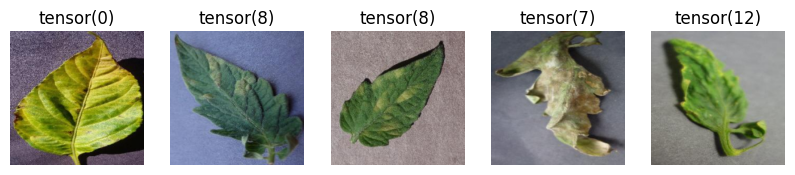

In [10]:

# Retrieve a single batch of images and labels from the train DataLoader
data_iter = iter(train_loader_3)
images, labels = next(data_iter)

# Print out basic info about the batch
print(f"Batch size: {images.size(0)}")
print(f"Image shape: {images.shape}")
print(f"Label sample: {labels[:5]}")    # Print first 5 labels to verify format and mapping

# Optional: Display a few images with their labels
def show_images(images, labels, num=5):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Convert images back to original scale before displaying (reverse normalization)
inv_transform = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
images_inv = inv_transform(images)

# Display images
show_images(images_inv, labels)


#Convolutional Neural Networks

In [11]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###Define Resnet-18 Model

In [12]:
def get_resnet_model(classes):

    # Initialize the ResNet-18 model
    model = resnet18(num_classes=len(classes)).to(device)  # Change to the correct number of classes

    return model

###Define vgg-16 Model

In [13]:
def get_vgg16_model(classes):
    # Initialize the VGG-16 model
    model = vgg16(num_classes=len(classes)).to(device)  # Set pretrained=True if you want to use pre-trained weights

    return model

###Define MobileNet Model


In [14]:
def get_mobilenet_model(classes):
    # Initialize the MobileNet v2 model
    model = mobilenet_v2(num_classes=len(classes)).to(device)  # Change to the correct number of classes
    return model

###Define function to reload the models

In [17]:
# Function to load the model
def load_model(model, path):
    # Load the model's state_dict from the file
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {path}")
    return model

#Testing

##Re-loading the saved models

In [18]:
resnet_model_1 = get_resnet_model(classes=class_labels_1)  # Initialize the model again (same as the one saved)
resnet_model_1 = load_model(resnet_model_1, "trained_models/resnet_model_1.pth")

resnet_model_2 = get_resnet_model(classes=class_labels_2)
resnet_model_2 = load_model(resnet_model_2, "trained_models/resnet_model_2.pth")

resnet_model_3 = get_resnet_model(classes=class_labels_3)
resnet_model_3 = load_model(resnet_model_3, "trained_models/resnet_model_3.pth")

vgg_model_1 = get_vgg16_model(classes=class_labels_1)
vgg_model_1 = load_model(vgg_model_1, "trained_models/vgg_model_1.pth")

vgg_model_2 = get_vgg16_model(classes=class_labels_2)
vgg_model_2 = load_model(vgg_model_2, "trained_models/vgg_model_2.pth")

vgg_model_3 = get_vgg16_model(classes=class_labels_3)
vgg_model_3 = load_model(vgg_model_3, "trained_models/vgg_model_3.pth")

mobilenet_model_1 = get_mobilenet_model(classes=class_labels_1)
mobilenet_model_1 = load_model(mobilenet_model_1, "trained_models/mobilenet_model_1.pth")

mobilenet_model_2 = get_mobilenet_model(classes=class_labels_2)
mobilenet_model_2 = load_model(mobilenet_model_2, "trained_models/mobilenet_model_2.pth")

mobilenet_model_3 = get_mobilenet_model(classes=class_labels_3)
mobilenet_model_3 = load_model(mobilenet_model_3, "trained_models/mobilenet_model_3.pth")

resnet_transfer_model_3 = get_resnet_model(classes=class_labels_3)
resnet_transfer_model_3 = load_model(resnet_transfer_model_3, "trained_models/resnet_transfer_model_3.pth")

mobilenet_transfer_model_2 = get_mobilenet_model(classes=class_labels_2)
mobilenet_transfer_model_2 = load_model(mobilenet_transfer_model_2, "trained_models/mobilenet_transfer_model_2.pth")

resnet_model_1_HT_batch_8_lr_01 = get_resnet_model(classes=class_labels_1)
resnet_model_1_HT_batch_8_lr_01 = load_model(resnet_model_1_HT_batch_8_lr_01, "trained_models/resnet_model_HT_batch_8_lr_0.01.pth")

models = [resnet_model_1, resnet_model_2, resnet_model_3, mobilenet_model_1, mobilenet_model_2, mobilenet_model_3, vgg_model_1, vgg_model_2, vgg_model_3, resnet_transfer_model_3, mobilenet_transfer_model_2, resnet_model_1_HT_batch_8_lr_01]

<ipython-input-17-ed0b2097167f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded from trained_models/resnet_model_1.pth
Model loaded from trained_models/resnet_model_2.pth
Model loaded from trained_models/resnet_model_3.pth
Model loaded from trained_models/vgg_model_1.pth
Model loaded from trained_models/vgg_model_2.pth
Model loaded from trained_models/vgg_model_3.pth
Model loaded from trained_models/mobilenet_model_1.pth
Model loaded from trained_models/mobilenet_model_2.pth
Model loaded from trained_models/mobilenet_model_3.pth
Model loaded from trained_models/resnet_transfer_model_3.pth
Model loaded from trained_models/mobilenet_transfer_model_2.pth
Model loaded from trained_models/resnet_model_HT_batch_8_lr_0.01.pth


##Defining the function to test models

In [19]:
def evaluate_model(model, test_loader, class_names):
    """
    Evaluates the model on the test dataset and computes metrics.
    """
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


###Evaluating all the trained models on test datasets

Evaluating Resnet-18 on Potato Disease Leaf Dataset
Accuracy: 0.9457
Precision: 0.9475
Recall: 0.9457
F1-Score: 0.9452

Classification Report:
              precision    recall  f1-score   support

Early_Blight       0.93      0.98      0.95       162
     Healthy       0.99      0.86      0.92       102
 Late_Blight       0.94      0.96      0.95       141

    accuracy                           0.95       405
   macro avg       0.95      0.94      0.94       405
weighted avg       0.95      0.95      0.95       405



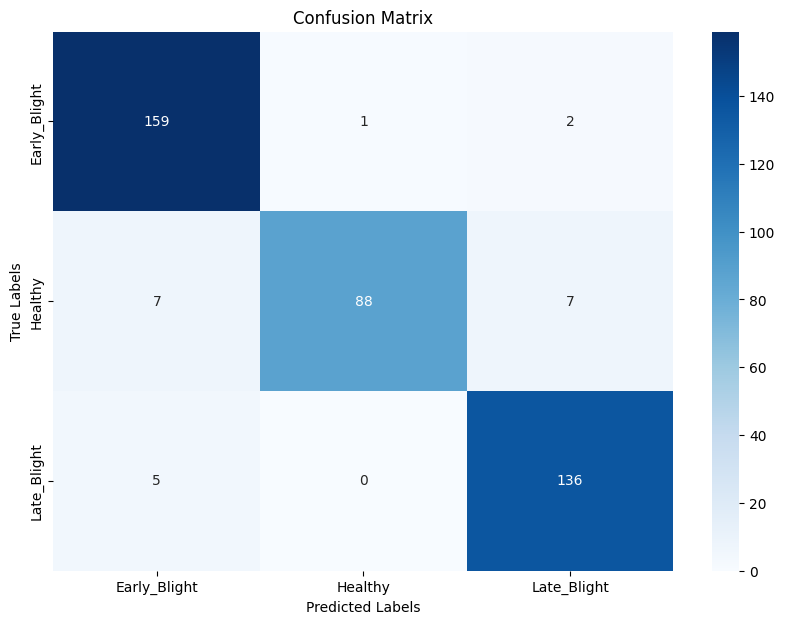


Evaluating Resnet-18 on Crop Diseases Classification Dataset


In [ ]:
print("Evaluating Resnet-18 on Potato Disease Leaf Dataset")
evaluate_model(resnet_model_1, test_loader_1, class_names=class_labels_1)

print("\nEvaluating Resnet-18 on Crop Diseases Classification Dataset")
evaluate_model(resnet_model_2, test_loader_2, class_names=class_labels_2)

print("\nEvaluating Resnet-18 on Plant Village Dataset")
evaluate_model(resnet_model_3, test_loader_3, class_names=class_labels_3)

print("\nEvaluating VGG-16 on Potato Disease Leaf Dataset")
evaluate_model(vgg_model_1, test_loader_1, class_names=class_labels_1)

print("\nEvaluating VGG-16 on Crop Diseases Classification Dataset")
evaluate_model(vgg_model_2, test_loader_2, class_names=class_labels_2)

print("\nEvaluating VGG-16 on Plant Village Dataset")
evaluate_model(vgg_model_3, test_loader_3, class_names=class_labels_3)

print("\nEvaluating MobileNet on Potato Disease Leaf Dataset")
evaluate_model(mobilenet_model_1, test_loader_1, class_names=class_labels_1)

print("\nEvaluating MobileNet on Crop Diseases Classification Dataset")
evaluate_model(mobilenet_model_2, test_loader_2, class_names=class_labels_2)

print("\nEvaluating MobileNet on Plant Village Dataset")
evaluate_model(mobilenet_model_3, test_loader_3, class_names=class_labels_3)

print("\nEvaluating Resnet-18 using transfer learning on Plant Village Dataset")
evaluate_model(resnet_transfer_model_3, test_loader_3, class_names=class_labels_3)

print("\nEvaluating MobileNet using transfer learning on Crop Diseases Classification Dataset")
evaluate_model(mobilenet_transfer_model_2, test_loader_2, class_names=class_labels_2)

print("\nEvaluating hyperparameter tuned Resnet-18 on Plant Village Dataset with batch size 8 and learning rate 0.01")
evaluate_model(resnet_model_1_HT_batch_8_lr_01, test_loader_1, class_names=class_labels_1)
